# 構成

- 画像を音楽に変換するプログラム. 
- defの集まり > main という構成. 
- 音楽制作はmelodyとloop(の繰り返し)の2種類で構成している. 

# Def /////////////////////////////////////////////////

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import chain, zip_longest
import random
import time
import math
import wave
import struct

# image

In [2]:
# is_length == 1 (True), partition_len = partition_num
# n次元のlstの最外殻を長さpartition_lenのサブリストたちに分ける
# 等分割できない場合: 最後の余り(長さpartition_len未満)は最後に追加される
# 例) partition1d([0,1,2,3,4], 2, 1) -> [[0,1],[2,3],[4]]
# 作成背景: 中身の本質は1行だが, 内容が直感的でないのであえてdef化. やめても良い
#--------
# is_length == 0 (False), group_num = partition_num
# n次元のlstの最外殻をgroup_num個のサブリストたちに分ける
# 等分割できない場合: 前半に"+1だけ長いサブリスト"たちを集めて, 元のlstの全要素を使い切る
# 例) partition1d([0,1,2,3], 2, 0)                 -> [[0,1],[2,3]]
# 例) partition1d([0,1,2], 2,0 )                     -> [[0,1],[2]]
# 例) partition1d([0,1,2,3,4], 2, 0)              -> [[0,1,2],[3,4]]
# 例) partition1d([[0,1],[2],3,[4,5]], 2, 0) -> [[[0, 1], [2]], [3, [4, 5]]]
def partition1d(lst, partition_num, is_length):
    if(is_length == 1):
        partition_len = partition_num
        partitioned_lst = list(zip(*[iter(lst)]*partition_len))

        rest_num = len(lst) % partition_len
        if( rest_num > 0 ):
            rest_lst = lst[(len(lst) - rest_num):len(lst)]
            partitioned_lst.append(rest_lst)

        # サブリストがタプルになってしまっているので, それぞれリストに変換
        # 修正希望: for使わないで, 関数で一発変換したい
        for i in range( len(partitioned_lst) ):
            partitioned_lst[i] = list( partitioned_lst[i] )

    if(is_length == 0):
        group_num = partition_num
        partition_len = int( len(lst) / group_num )
        longer_lst_num = len(lst) % group_num
        
        if longer_lst_num == 0 :
            partitioned_lst = partition1d(lst, partition_len, 1)
        elif longer_lst_num > 0 :
            # longer_lst_num個の"+1だけ長いサブリスト"たちを作る
            partitioned_former_lst = partition1d(lst, partition_len+1, 1)[0:longer_lst_num]
            rest_lst = lst[ (partition_len+1)*longer_lst_num : len(lst) ]
            partitioned_latter_lst = partition1d(rest_lst, partition_len, 1)
            partitioned_lst = partitioned_former_lst + partitioned_latter_lst[0:len(partitioned_latter_lst)]

    return(partitioned_lst)

In [3]:
# 2次元arrayをrow_grid_num x column_grid_numのグリッドに分割する
# 2次元arrayの各要素がarrayでも良い(例: np.array([r,g,b])). 全要素の次元は同じである必要がある. 
# 要修正: サブリストはarrayだが, partitioned_array自体はlist. 全体をarrayとしてまとめたい. 
#              等分割できなくてサブリスト同士のshapeが違う場合, 最後にnp.arrayをかけるとエラーが出る(例2の場合)
# 例0: array = np.array([[1,2],[3,4]]), partition2d(array,1,1) -> [[array([[1,2],[3,4]])]]
# 例1: array = np.array([[1,2],[3,4]]), partition2d(array,2,2) -> [[array([[1]]), array([[2]])], [array([[3]]), array([[4]])]]
# 例2: array = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]]), partition2d(array,2,2)
#                  -> [[array([[1,2],[4,5]]), array([[3],[6]])], [array([[7,8],[10,11]]), array([[9],[12]])]]
# 例3: array = np.array([[[1],[2]],[[3],[4]]]), partition2d(array,2,2)
#                  -> [[array([[[1]]]), array([[[2]]])], [array([[[3]]]), array([[[4]]])]]
def partition2d(array, row_grid_num, column_grid_num):
    all_column_num, all_row_num = array.shape[0:2]
    # arrayの要素を取り出すための番号(id)のリストを作成
    column_id_lst =  partition1d(range(all_column_num), column_grid_num, 0)
    row_id_lst =  partition1d(range(all_row_num), row_grid_num, 0)
    
    partitioned_array = []
    for column in range(column_grid_num):
        a_column = []
        for row in range(row_grid_num):
            a_column.append( array[column_id_lst[column][0]:(column_id_lst[column][-1]+1), row_id_lst[row][0]:(row_id_lst[row][-1]+1) ] )
        partitioned_array.append(a_column)

    return(partitioned_array)

In [4]:
# imgの平均値の色を求める. 
# 例: img=[[[4,10,1],[40,10,2]],[[400,10,3],[4000,10,4]]]  ->  array([ 1111. ,    10. ,     2.5])
# 要修正: 2次元以上のarrayなら使用できるので, より一般的なdef名にrenameすべき
def to_mean(img):
    flattened_img = np.array(list(chain.from_iterable(np.float_(img))))
    mean_color =  sum(flattened_img)/len(flattened_img)
    return(mean_color)

In [5]:
# 注意: webで見つけてきたそのまま. openCVのとは違い, 各値をfloatで変換. 
# R, G, B values are [0, 255]. H value is [0, 360]. S, V values are [0, 1].
def hsv2rgb(h, s, v):
    h = float(h)
    s = float(s)
    v = float(v)
    h60 = h / 60.0
    h60f = math.floor(h60)
    hi = int(h60f) % 6
    f = h60 - h60f
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    r, g, b = 0, 0, 0
    if hi == 0: r, g, b = v, t, p
    elif hi == 1: r, g, b = q, v, p
    elif hi == 2: r, g, b = p, v, t
    elif hi == 3: r, g, b = p, q, v
    elif hi == 4: r, g, b = t, p, v
    elif hi == 5: r, g, b = v, p, q
    r, g, b = int(r * 255), int(g * 255), int(b * 255)
    return r, g, b
    
def rgb2hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return h, s, v

In [6]:
# 時計回り(右, 上, 左, 下)に候補のidのリストを作成
def make_all_candidate(present_id, shift):
    id_width, id_height = present_id
    
    candidates = [
        [id_width + shift, id_height],
        [id_width,             id_height + shift],
        [id_width - shift,  id_height],
        [id_width,             id_height - shift]
        ]
    return(candidates)

#present_id = [1,1]
#shift = 1
#candidates = make_all_candidate(present_id, shift)
#print(candidates)

In [7]:
def dont_back(previous_id, candidates):
    available_candidates = []
    
    for i in range(len (candidates)):
        if(candidates[i] != previous_id):
            available_candidates.append(candidates[i])
            
    return(available_candidates)

#previous_id = [1,2]
#path_order = 1
#candidates = [[2,1], [1,2], [0,1], [1,0]]
#if(path_order >= 1):
#    candidates = dont_back(previous_id, candidates)
#print(candidates)

In [8]:
def select_available(present_id, candidates, id_minmax):
    id_width, id_height = present_id
    id_width_min, id_width_max, id_height_min, id_height_max = id_minmax
    available_candidates = []
    
    for i in range(len (candidates)):
        candidate = candidates[i]
        # in range
        if( (id_width_min <= candidate[0] <= id_width_max) and (id_height_min <= candidate[1] <= id_height_max)):
            available_candidates.append(candidate)
        # id_widthが大き過ぎたら, id_width_maxに合わせる
        elif( (candidate[0] > id_width_max) and (id_width < id_width_max) and (id_height_min <= candidate[1] <= id_height_max)):
            available_candidates.append([id_width_max, candidate[1]])
        # id_widthが小さ過ぎたら, id_width_minに合わせる
        elif( (candidate[0] < id_width_min) and (id_width > id_width_min) and (id_height_min <= candidate[1] <= id_height_max)):
            available_candidates.append([id_width_min, candidate[1]])
        # id_heightが大き過ぎたら, id_height_maxに合わせる
        elif( (candidate[1] > id_height_max) and (id_height < id_height_max) and (id_width_min <= candidate[0] <= id_width_max)):
            available_candidates.append([candidate[0], id_height_max])
        # id_heightが小さ過ぎたら, id_height_minに合わせる
        elif( (candidate[1] < id_height_min) and (id_height > id_height_min) and (id_width_min <= candidate[0] <= id_width_max)):
            available_candidates.append([candidate[0], id_height_min])
    
    return(available_candidates)


#present_id = [1,1]
#candidates = [[20,1], [0,1], [1,0]]
#id_minmax = [0, partition_num_width  - 1, 0, partition_num_height-  1]
#candidates = select_available(present_id, candidates, id_minmax)
#print(candidates)

In [9]:
def decide_next(present_id, candidates, reduced_color, selection_mode):
    id_width, id_height = present_id
    
    id_and_gap = []
    dtype = [('candidate_id_width', 'int'), ('candidate_id_height', 'int'), ('gap', 'float')]
    for i in range(len(candidates)):
        candidate_id_width, candidate_id_height = candidates[i]
        id_and_gap.append(tuple([candidate_id_width, candidate_id_height, reduced_color[id_height, id_width] - reduced_color[candidate_id_height, candidate_id_width]]))
        
    id_and_gap = list( np.sort(np.array(id_and_gap, dtype=dtype), order='gap') )
    
    # tuple2list for elements
    for i in range(len(id_and_gap)):
        id_and_gap[i] = list(id_and_gap[i])

    if(selection_mode == "closest"):
        next_id_width  = id_and_gap[0][0]
        next_id_height = id_and_gap[0][1]
    elif(selection_mode == "most_different"):
        next_id_width  = id_and_gap[len(id_and_gap)-1][0]
        next_id_height = id_and_gap[len(id_and_gap)-1][1]

    next_id = [next_id_width, next_id_height]

    return(next_id)

#present_id = [1,1]
#candidates = [[2,1], [0,1], [1,0]]
#reduced_h = reduced_hsv[:,:,0]
#next_id = compare_color(present_id, candidates, reduced_h)
#print( next_id )

In [10]:
def decide_shift(present_id, unique_past_id, shift_lst):
    id_width, id_height = present_id

    if( set([str(id_width)+","+str(id_height)]).issubset(unique_past_id) ):
        shift_lst[id_height][id_width] += 1

    shift = shift_lst[id_height][id_width]
        
    return([shift, shift_lst])

#unique_past_id = set(['1,2','2,3','1,1'])
#print(unique_past_id)
#shift, shift_lst = decide_shift([1,1], unique_past_id, shift_lst)
#print(shift)
#print(shift_lst)

In [11]:
def jump_unknown(present_id, unique_past_id, unique_all_id, reduced_color, selection_mode):
    unique_rest_id = unique_all_id.difference(unique_past_id)
    rest_id = list(unique_rest_id)

    # str2int
    for i in range(len(rest_id)):
        rest_id[i] = rest_id[i].split(',')
        rest_id[i] = [int(rest_id[i][0]), int(rest_id[i][1])]

    next_id = decide_next(present_id, rest_id, reduced_color, selection_mode)
    return(next_id)

#repeatable_num = 0
#present_id = [1,2]
#next_id = [1,0]
#unique_past_id = set(['1,2','2,3','1,0'])
#next_id_width, next_id_height = next_id
#repeat_num = shift_lst[next_id_height][next_id_width]
#print(repeat_num)
#if( repeat_num > repeatable_num ):
#    next_id = jump_unknown(present_id, unique_past_id, unique_all_id, reduced_h)
#
#print(next_id)

In [12]:
def mk_reduced_color_img(img_size, partition_num_width, partition_num_height, log_id, reduced_rgb, label_name):
    element_img_size = int(img_size/max([partition_num_height, partition_num_width])) # pixel
    print(element_img_size)
    reduced_color_img = np.zeros((element_img_size*partition_num_height, element_img_size*partition_num_width, 3), np.uint8)
    pointer_edge_px = int(element_img_size/3)

    for path_order in range(len(log_id)):
        id_width, id_height = log_id[path_order]

        img_pt1 = [element_img_size*id_width,                 element_img_size*id_height]
        img_pt2 = [element_img_size*(id_width + 1) - 1, element_img_size*(id_height + 1) - 1]
        pt_pt1   = [img_pt1[0] + pointer_edge_px,       img_pt1[1] + pointer_edge_px]
        pt_pt2   = [img_pt2[0] -  pointer_edge_px - 1, img_pt2[1] -  pointer_edge_px - 1]
        cv2.rectangle(reduced_color_img, (img_pt1[0], img_pt1[1]), (img_pt2[0], img_pt2[1]), reduced_rgb[id_height, id_width], -1, 0)
        cv2.rectangle(reduced_color_img, (pt_pt1[0],    pt_pt1[1]),   (pt_pt2[0],    pt_pt2[1]),   np.array([255.,255.,255.]),            -1, 0)
        cv2.imwrite("path_"+label_name+"/reduced_color_img_"+str(path_order)+".jpg", cv2.cvtColor(reduced_color_img,cv2.COLOR_RGB2BGR) )
        cv2.rectangle(reduced_color_img, (img_pt1[0], img_pt1[1]), (img_pt2[0], img_pt2[1]), reduced_rgb[id_height, id_width], -1, 0)

    return(reduced_color_img)

In [13]:
# make normalized 1d_array
# ex) array([1, 3, 5]) >> array([0., 0.5, 1.])
def normalize1d(array):
    array_min  = min(array)
    array_max = max(array)

    normalized_array = []
    for i in range(len(array)):
        normalized_array.append( (array[i] - array_min)/(array_max - array_min) )
    normalized_array = np.array(normalized_array)
    
    return(normalized_array)

In [14]:
# make 1d-array along path
# ex) path_h = path_array(log_id, reduced_hsv[:,:,0])
def path_array(log_id, input_array):
    array = []
    for path_order in range(len(log_id)):
        id_width, id_height = log_id[path_order]
        array.append(input_array[id_height, id_width])
    array = np.array(array)
    return(array)

In [15]:
def mk_reduced_rgb(partitioned_img, partition_num_height, partition_num_width):
    reduced_rgb = []
    for id_height in range(partition_num_height):
        a_width_rgb = []
        for id_width in range(partition_num_width):
            a_width_rgb.append( to_mean(partitioned_img[id_height][id_width]) )
        reduced_rgb.append(a_width_rgb)
    reduced_rgb = np.array(reduced_rgb)

    return(reduced_rgb)


def mk_reduced_hsv(partitioned_img, partition_num_height, partition_num_width):
    reduced_hsv = []
    for id_height in range(partition_num_height):
        a_width_hsv = []
        for id_width in range(partition_num_width):
            mean_rgb = to_mean(partitioned_img[id_height][id_width])
            a_width_hsv.append( rgb2hsv(mean_rgb[0], mean_rgb[1], mean_rgb[2]) )
        reduced_hsv.append(a_width_hsv)
    reduced_hsv = np.array(reduced_hsv)

    return(reduced_hsv)

In [16]:
def img2path(img, partition_num_width, partition_num_height, last_path_order, first_shift, repeatable_num):

    first_id_width = int(partition_num_width/2)
    first_id_height = int(partition_num_height/2)

    unique_all_id = []
    for id_height in range(partition_num_height):
        for id_width in range(partition_num_width):
            unique_all_id.append(str(id_width)+","+str(id_height))
    unique_all_id = set(unique_all_id)

    partitioned_img = partition2d(img, partition_num_width, partition_num_height)

    id_minmax = [0, partition_num_width  - 1, 0, partition_num_height-  1]

    reduced_rgb = mk_reduced_rgb(partitioned_img, partition_num_height, partition_num_width)
    print(reduced_rgb.shape)

    reduced_hsv = mk_reduced_hsv(partitioned_img, partition_num_height, partition_num_width)
    print(reduced_hsv.shape)

    reduced_h = reduced_hsv[:,:,0]

    path_order = 0
    reduced_color = reduced_h
    unique_past_id = set([])

    while (len(unique_past_id) != len(unique_all_id)) and (path_order <= last_path_order) :
        if(path_order == 0):
            present_id = [first_id_width, first_id_height]
            log_id = [present_id]
            shift = first_shift
            shift_lst = []
            for i in range(partition_num_height):
                a_width_shift = []
                for j in range(partition_num_width):
                    a_width_shift.append(first_shift)
                shift_lst.append(a_width_shift)

        if(path_order >= 1):
            previous_id = present_id
            present_id = next_id
            log_id.append(present_id)
            shift, shift_lst = decide_shift(present_id, unique_past_id, shift_lst)

        candidates = make_all_candidate(present_id, shift)

        if(path_order >= 1):
            candidates = dont_back(previous_id, candidates)

        candidates = select_available(present_id, candidates, id_minmax)

        next_id = decide_next(present_id, candidates, reduced_color, "closest")

        next_id_width, next_id_height = next_id
        repeat_num = shift_lst[next_id_height][next_id_width]
        if( repeat_num > repeatable_num ):
            next_id = jump_unknown(present_id, unique_past_id, unique_all_id, reduced_h, "most_different")

        unique_past_id.add( str(present_id[0])+","+str(present_id[1]) )

        path_order += 1
        
        
    return(log_id, reduced_rgb, reduced_hsv)

# music

In [17]:
# def名を坂口のmakewaveからmakewave0に変更(重複を避けるため)
def makewave0(amp,freq,sec,sr):
    outwave = []
    for i in range( int(sec*sr) ) :
        w = amp*np.sin(2*np.pi*freq*i/sr)
        outwave.append(w)
    return(outwave)


def wavwrite(inputlist,filename):
    maxamp = 32767.0
    int16wave = [int(x * maxamp) for x in inputlist]
    binwave = struct.pack("h"*len(int16wave),*int16wave)

    nchannnles = 1 # 1=monoral , 2=stereo
    sampwitdth = 2 # 1=8bit,2=16bit,3=,...
    framerate = 44100 # sampling rate ex.44100Hz
    nframes = len(inputlist) # framerate * sec
    
    of = wave.open(filename,"w")
    of.setparams((nchannnles,sampwitdth,framerate,nframes,"NONE","not compressed"))
    of.writeframes(binwave)
    of.close
    
    
# amp_typeでamplitudeの形の選択が可能. 
# 要修正: 使いづらいので整理する必要あり
def ampFn(amp_type,t,t0,T,amp,aparam):
    # t0: initial time
    # T: length of time for sound
    # t1: time of peak
    # a1: trancation exponent(a1=1: NoEffect, 1<<a1: too tracate)
    # a2: trancation exponent(0<a2, 0<a2<<1: too tracate, 1<<a2: NoEffect
    # a1=-1&a2=1: convex trancation shape
    t1 = aparam[0]
    a1 = aparam[1]
    a2 = aparam[2]
    if amp_type == 1:
        if t <= t0:
            ampVal = 0
        else:
            if t <= t0 + t1:
                ampVal = amp*(t-t0)/t1
            else:
                ampVal = amp*(-(t-T)/T)*((t1+a2)/(t-t0+a2))**a1
    elif amp_type == 2:
        if t <= t0:
            ampVal = 0
        else:
            ampVal = amp*(1-(t-t0)/T)**2
    elif amp_type == 3:
        if t <= t0:
            ampVal = 0
        else:
            ampVal = amp*(1-((t-t0)/T)**(1/10))

    if ampVal > 5:
        ampVal = 5

    return(ampVal)


# wave_typeで基礎波形の選択が可能
# 要修正: 使いづらいので整理する必要あり
def waveFn(wave_type,t,t1,param,freq):
    #Sin Wave
    if   wave_type == 1:
        wave = np.sin(2*np.pi * freq*t)
    #Sawtooth Wave
    elif wave_type == 2:
        wave = 2*((t-t1)*freq - np.floor((t-t1)*freq + 0.5))
    #Triangle Wave
    elif wave_type == 3:
        wave = 2*abs(2*((t-t1+1/(4*freq))*freq - np.floor((t-t1+1/(4*freq))*freq + 0.5)))-1
    #Square Wave
    elif wave_type == 4:
        wave = np.sign(np.sin(2*np.pi * freq*t))
    #Pulse Wave 1
    elif wave_type == 5:
        wave = np.sign(- (t-t1)*freq + np.floor((t-t1)*freq) + param[0])
    return(wave)



# ampFnとwaveFnを組み合わせて1つのfreqがT秒間鳴る音を作成
# 要修正: 使いづらいので整理する必要あり
# 要修正: def名が坂口作成のと同じなので注意
def makewave(amp, freq, T, sr, aparam):
    outwave = []
    dt = 1/sr
    t0 = 0
    for t in np.arange( 0., T+dt, dt ) :
        # 倍音作成のためにwaveFnが複数ある. 
        w = ampFn(2, t, t0, T, amp, aparam) * ( waveFn(1, t, 0, 1, freq) + waveFn(1, t, 0, 1, 2*freq)/4 + waveFn(1, t, 0, 1, 3*freq)/6 + waveFn(1, t, 0, 1, 4*freq)/8 )
        outwave.append(w)
    return(outwave)

In [18]:
# ex) all_key_id, octave_num = set_key("white")
def set_key(keyname):
    if(keyname == "all"):
        base_key_id = list(range(12))
    elif(keyname == "white"):
        base_key_id = [0,2,4,5,7,9,11]
    elif(keyname == "black"):
        base_key_id = [  1,3,   6, 8, 10]
    elif(keyname[len(keyname)-2:len(keyname)] == "mj"):
        base_major_key_id = [0,2,4,5,7,9,11]
        if(keyname ==    "Af_mj"):
            base_key_id = list(np.array(base_major_key_id) - 4)
        elif(keyname == "A_mj"):
            base_key_id = list(np.array(base_major_key_id) - 3)
        elif(keyname == "Bf_mj"):
            base_key_id = list(np.array(base_major_key_id) - 2)
        elif(keyname == "B_mj"):
            base_key_id = list(np.array(base_major_key_id) - 1)
        elif(keyname == "Cf_mj"):
            base_key_id = list(np.array(base_major_key_id) - 1)
        elif(keyname == "C_mj"):
            base_key_id = list(np.array(base_major_key_id) + 0)
        elif(keyname == "Cs_mj"):
            base_key_id = list(np.array(base_major_key_id) + 1)
        elif(keyname == "Df_mj"):
            base_key_id = list(np.array(base_major_key_id) + 1)
        elif(keyname == "D_mj"):
            base_key_id = list(np.array(base_major_key_id) + 2)
        elif(keyname == "Eb_mj"):
            base_key_id = list(np.array(base_major_key_id) + 3)
        elif(keyname == "E_mj"):
            base_key_id = list(np.array(base_major_key_id) + 4)
        elif(keyname == "F_mj"):
            base_key_id = list(np.array(base_major_key_id) + 5)
        elif(keyname == "Fs_mj"):
            base_key_id = list(np.array(base_major_key_id) + 6)
        elif(keyname == "Gf_mj"):
            base_key_id = list(np.array(base_major_key_id) + 6)
        elif(keyname == "G_mj"):
            base_key_id = list(np.array(base_major_key_id) + 7)
    elif(keyname[len(keyname)-2:len(keyname)] == "mn"):
        base_major_key_id = [0,2,3,5,7,8,10,12]
        if(keyname ==    "Af_mn"):
            base_key_id = list(np.array(base_major_key_id) - 4)
        elif(keyname == "A_mn"):
            base_key_id = list(np.array(base_major_key_id) - 3)
        elif(keyname == "As_mn"):
            base_key_id = list(np.array(base_major_key_id) - 2)
        elif(keyname == "Bf_mn"):
            base_key_id = list(np.array(base_major_key_id) - 2)
        elif(keyname == "B_mn"):
            base_key_id = list(np.array(base_major_key_id) - 1)
        elif(keyname == "C_mn"):
            base_key_id = list(np.array(base_major_key_id) + 0)
        elif(keyname == "Cs_mn"):
            base_key_id = list(np.array(base_major_key_id) + 1)
        elif(keyname == "D_mn"):
            base_key_id = list(np.array(base_major_key_id) + 2)
        elif(keyname == "Ds_mn"):
            base_key_id = list(np.array(base_major_key_id) + 3)
        elif(keyname == "Ef_mn"):
            base_key_id = list(np.array(base_major_key_id) + 3)
        elif(keyname == "E_mn"):
            base_key_id = list(np.array(base_major_key_id) + 4)
        elif(keyname == "F_mn"):
            base_key_id = list(np.array(base_major_key_id) + 5)
        elif(keyname == "Fs_mn"):
            base_key_id = list(np.array(base_major_key_id) + 6)
        elif(keyname == "G_mn"):
            base_key_id = list(np.array(base_major_key_id) + 7)
        elif(keyname == "Gs_mn"):
            base_key_id = list(np.array(base_major_key_id) + 8)
        
    octave_num = len(base_key_id)
    
    all_key_id = []
    for i in range(0, 10):
        all_key_id.append( np.array(base_key_id)+12*i )
    all_key_id = list( np.concatenate(all_key_id) )
    
    return(all_key_id, octave_num)


# ex) "white", freq = value2freq(3, 1, 0, all_key_id, octave_num, 0.01) >> 130.8(C3)
# ex) "white", freq = value2freq(3, 1, 0, all_key_id, octave_num, 0.2)   >> 146.8(D3)
def value2freq(first_octave, plus_octave, key_id_shift, all_key_id, octave_num, normalized_value):
    first_key_id = octave_num*first_octave + key_id_shift
    last_key_id = octave_num*(first_octave + plus_octave) + key_id_shift
    key_id_gap = last_key_id - first_key_id

    key_id = all_key_id[ int( first_key_id + key_id_gap * normalized_value ) ]
    freq = 16.35159783 * ( (math.pow(2.0, key_id))**(1.0/12.0) )

    return(freq)

#all_key_id, octave_num = set_key("white")
#freq = value2freq(3, 1, 0, all_key_id, octave_num, 0.2)
#print(freq)

In [19]:
def unify1d(lst0, lst1):
    len0 = len(lst0)
    len1 = len(lst1)
    aft0 = max([len0, len1])-len0
    aft1 = max([len0, len1])-len1
    unified_lst = np.lib.pad(lst0,(0, aft0),"constant",constant_values = 0) + np.lib.pad(lst1,(0, aft1),"constant",constant_values = 0)
    return(unified_lst)

In [20]:
#ex) value2first_time([0,1,20], 1, 0.1, 10, 0.1) >> 21.0
def value2first_time(path_first_time, isnt_degeneratable, time_element, first_time_ratio, normalized_value):
    if(len(path_first_time) == 0):
        first_time = 0
    elif(len(path_first_time) > 0):
        previous_first_time = path_first_time[-1]
        first_time = (previous_first_time + isnt_degeneratable*time_element) + int(first_time_ratio*(1 - normalized_value))*time_element

    return(first_time)

In [21]:
def value2time_length(path_order, len_id_usage, time_element, time_1loop, time_length_ratio, first_time, normalized_value):
    time_length = time_element + int(time_length_ratio*(1 - normalized_value))*time_element
    last_time = first_time + time_length
    is_over = int(last_time / time_1loop) - int(first_time / time_1loop)
    over_time = last_time % time_1loop
    if( is_over > 0 ):
        time_length = int(last_time / time_1loop)*time_1loop - first_time
        last_time = int(last_time / time_1loop)*time_1loop
        
    aft = 0
    if path_order == len_id_usage - 1:
        aft = int( ( (int(last_time / time_1loop) + 1)*time_1loop - last_time )*sr)
        
    return(time_length, last_time, aft)

#time_element = 0.1
#time_1loop = 16*time_element
#print(time_1loop)
#time_length_ratio = 4
#first_time = 1.6
#normalized_value = 0.01
#time_length, last_time = value2time_length(time_element, time_1loop, time_length_ratio, first_time, normalized_value)
#print([time_length, last_time])
#1.6
#[0.4, 2.0]

In [22]:
def path2wave(path_normalized_hsv, keyname, first_octave, plus_octave, key_id_shift, first_time_ratio, time_length_ratio, isnt_degeneratable, bpm, loop_count, len_id_usage):
    path_normalized_h, path_normalized_s, path_normalized_v = path_normalized_hsv
    
    all_key_id, octave_num = set_key(keyname)
    bps = bpm/60
    time_1count    = 1/bps
    time_element   = time_1count/2
    time_1loop       = loop_count*time_1count
    time_half_loop = time_1loop/2

    path_freq = []
    path_first_time = []
    path_time_length = []
    for path_order in range(len_id_usage):
        nml_h = path_normalized_h[path_order]
        nml_s = path_normalized_s[path_order]
        nml_v = path_normalized_v[path_order]

        freq = value2freq(first_octave, plus_octave, key_id_shift, all_key_id, octave_num, nml_h)
        path_freq.append(freq)

        first_time = value2first_time(path_first_time, isnt_degeneratable, time_element, first_time_ratio, nml_s)
        path_first_time.append(first_time)

        time_length, last_time, aft = value2time_length(path_order, len_id_usage, time_element, time_1loop, time_length_ratio, first_time, nml_v)
        path_time_length.append(time_length)

        aparam = [0.02*time_length*nml_v, 1, 0.1*nml_v] #t1,a1,a2
        bfr = int(first_time*sr)
        sound_wave = makewave(1, freq, time_length, sr, aparam)
        sound_wave = np.lib.pad(sound_wave, (bfr, aft), "constant", constant_values = 0)
        if(path_order == 0):
            unified_sound_wave = sound_wave
        elif(path_order > 0):
            unified_sound_wave = unify1d(sound_wave, unified_sound_wave)

    return(unified_sound_wave, path_freq, path_first_time, path_time_length)

# Main ///////////////////////////////////////////////////////////

In [23]:
start_whole_time = time.time()
sr = 44100 # sampling rate

## read image

(2171, 1757, 3)


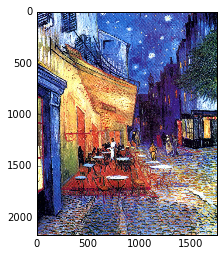

In [24]:
#img = cv2.imread("../../_fig/_others/keitasumiya.jpg")
#img = cv2.imread("../../_fig/picasso/crying_woman.jpg")
img = cv2.imread("../../_fig/goch/cafe_terrace_at_night.jpg")
img_name = "goch"
#img = cv2.imread("../../_fig/_others/miporin.jpg")
#img = cv2.imread("../../_fig/monet/woman_withparasol.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#height, width, channels = img.shape
print(img.shape)
plt.imshow(img)

## melody part  --------------------------------------
### image

In [25]:
partition_num_width = 10
partition_num_height = 10
last_path_order = 100
first_shift = 1
repeatable_num = 3

log_id, reduced_rgb, reduced_hsv = img2path(img, partition_num_width, partition_num_height, last_path_order, first_shift, repeatable_num)

(10, 10, 3)
(10, 10, 3)


In [26]:
print(log_id)

[[5, 5], [5, 4], [5, 3], [6, 3], [6, 4], [5, 4], [7, 4], [7, 5], [8, 5], [8, 6], [7, 6], [6, 6], [6, 5], [7, 5], [5, 5], [5, 3], [7, 3], [7, 4], [5, 4], [8, 4], [8, 5], [6, 5], [6, 3], [6, 1], [6, 0], [7, 0], [8, 0], [8, 1], [8, 2], [7, 2], [7, 3], [7, 5], [7, 2], [7, 4], [7, 1], [7, 2], [7, 5], [7, 9], [8, 9], [9, 9], [9, 8], [9, 7], [9, 6], [8, 6], [6, 6], [4, 6], [3, 6], [2, 6], [2, 7], [2, 8], [3, 8], [4, 8], [5, 8], [6, 8], [6, 9], [7, 9], [5, 9], [5, 8], [3, 8], [3, 6], [1, 6], [1, 7], [2, 7], [2, 9], [2, 8], [4, 8], [4, 6], [6, 6], [3, 6], [0, 6], [0, 5], [0, 4], [0, 3], [1, 3], [1, 2], [1, 1], [2, 1], [3, 1], [3, 2], [4, 2], [5, 2], [5, 3], [8, 3], [7, 3], [7, 6], [7, 4], [7, 0], [7, 2], [3, 2], [5, 2], [5, 4], [5, 8], [2, 8], [2, 9], [2, 7], [2, 9], [0, 9], [1, 9], [2, 9], [0, 9], [0, 7]]


40


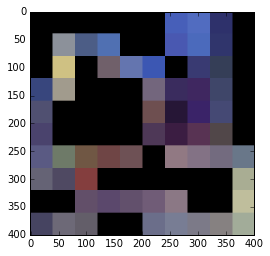

In [27]:
img_size = 400 # pixel
reduced_color_img = mk_reduced_color_img(img_size, partition_num_width, partition_num_height, log_id, reduced_rgb, "melody")
plt.imshow(reduced_color_img)

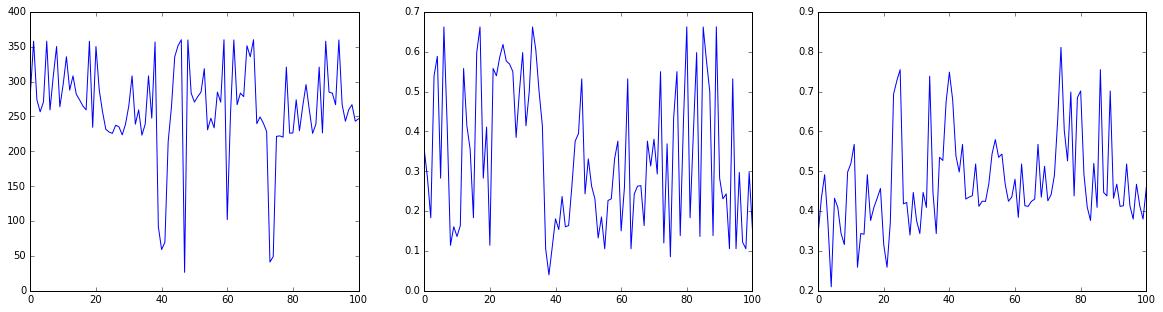

In [28]:
path_h = path_array(log_id, reduced_hsv[:,:,0])
path_s = path_array(log_id, reduced_hsv[:,:,1])
path_v = path_array(log_id, reduced_hsv[:,:,2])

path_normalized_h = normalize1d(path_h)
path_normalized_s = normalize1d(path_s)
path_normalized_v = normalize1d(path_v)
path_normalized_hsv = [path_normalized_h, path_normalized_s, path_normalized_v]

# plot hsv
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
ax1.plot(path_h)
ax2.plot(path_s)
ax3.plot(path_v)

### musicize

In [29]:
is_cut_loop = 0
cut_loop_num = 1
is_loop = 0
keyname = "C_mj"
first_octave = 4 # ex: 0=[C0, C#0, ..., C1] for "all"
plus_octave = 1
key_id_shift = 0 # ex: 0=C=ド for "all"

first_time_ratio = 2
time_length_ratio = 4
isnt_degeneratable = 1
bpm = 150
loop_count = 8
len_id_usage = len(log_id)

bps = bpm/60
time_1count    = 1/bps
time_element   = time_1count/2
time_1loop       = loop_count*time_1count

unified_sound_wave, path_freq, path_first_time, path_time_length = path2wave(path_normalized_hsv, keyname, first_octave, plus_octave, key_id_shift, first_time_ratio, time_length_ratio, isnt_degeneratable, bpm, loop_count, len_id_usage)
if is_cut_loop == 1:
    len_1loop = int(cut_loop_num*time_1loop*sr)
    unified_sound_wave = unified_sound_wave[0:len_1loop]
    path_freq                   = path_freq[0:len_1loop]
    path_first_time         = path_first_time[0:len_1loop]
    path_time_length     = path_time_length[0:len_1loop]

raw_unified_sound_wave = unified_sound_wave

whole_time_length = len(unified_sound_wave)/sr
print(len(unified_sound_wave))
print(time_1count, 'sec ', time_1loop, 'sec')
print(whole_time_length, 'sec')
print(whole_time_length/time_1count, ' counts')
print(whole_time_length/time_1loop, ' loop')

1411201
0.4 sec  3.2 sec
32.000022675736965 sec
80.0000566893424  counts
10.0000070861678  loop


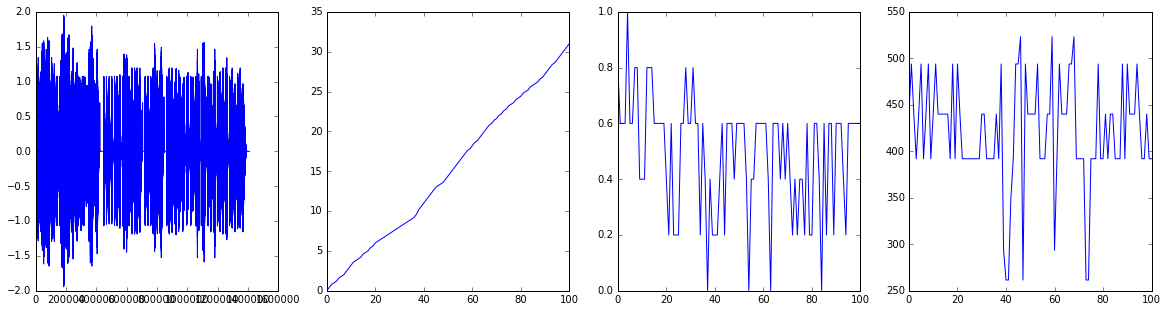

In [30]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3, ax4 = fig.add_subplot(141), fig.add_subplot(142), fig.add_subplot(143), fig.add_subplot(144)

#C3:130.81, B3:246.94, C4:261.63, B4:493.88, C5:523,25
ax1.plot(unified_sound_wave)
ax2.plot(path_first_time)
ax3.plot(path_time_length)
ax4.plot(path_freq)

In [31]:
if is_loop == 1:
    unified_sound_wave = np.array(int(len(unified_sound_wave_melody)/len(raw_unified_sound_wave) + 1)*list(raw_unified_sound_wave))
    unified_sound_wave_loop = unified_sound_wave    

max_amp = max(abs(unified_sound_wave))
print(max_amp)
unified_sound_wave = unified_sound_wave/max_amp
wavwrite(unified_sound_wave,"music_w"+str(partition_num_width)+"h"+str(partition_num_height)+".wav")

1.95263793445


In [32]:
img_prm = [partition_num_width, partition_num_height, last_path_order, first_shift, repeatable_num]
msc_prm = [is_cut_loop, cut_loop_num, is_loop, keyname, first_octave, plus_octave, key_id_shift, loop_count, first_time_ratio, time_length_ratio, isnt_degeneratable, bpm, len_id_usage]
prm_mldy = 'mldy_' + '-'.join(list(map(str, img_prm))) + '_' + '-'.join(list(map(str, msc_prm)))
prm_mldy

'mldy_10-10-100-1-3_0-1-0-C_mj-4-1-0-8-2-4-1-150-101'

In [33]:
log_id_melody = log_id
reduced_rgb_melody = reduced_rgb
reduced_hsv_melody = reduced_hsv

unified_sound_wave_melody = raw_unified_sound_wave
partition_num_width_melody = partition_num_width
partition_num_height_melody = partition_num_height

## loop part --------------------------------------------------
### image

In [34]:
partition_num_width = 3
partition_num_height = 3
last_path_order = 100
first_shift = 1
repeatable_num = 3

log_id, reduced_rgb, reduced_hsv = img2path(img, partition_num_width, partition_num_height, last_path_order, first_shift, repeatable_num)

(3, 3, 3)
(3, 3, 3)


In [35]:
print(log_id)
print(len(log_id))

[[1, 1], [1, 2], [0, 2], [0, 1], [0, 0], [1, 0], [2, 0], [2, 1], [2, 2]]
9


133


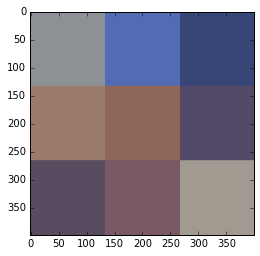

In [36]:
img_size = 400 # pixel
reduced_color_img = mk_reduced_color_img(img_size, partition_num_width, partition_num_height, log_id, reduced_rgb, "loop")
plt.imshow(reduced_color_img)

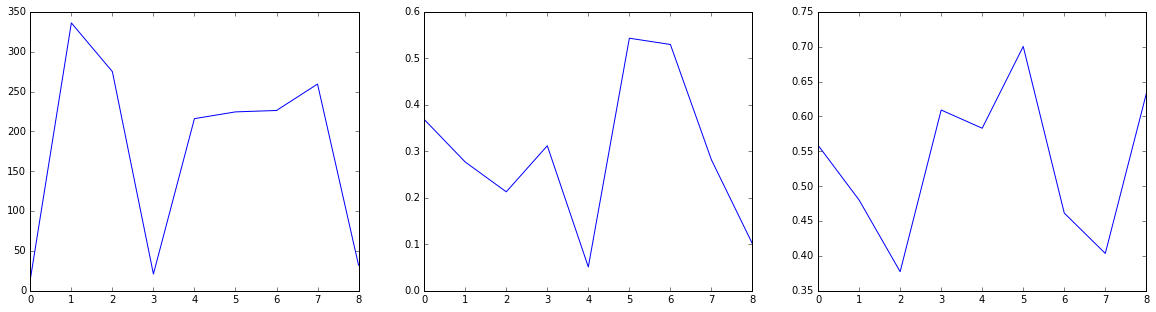

In [37]:
path_h = path_array(log_id, reduced_hsv[:,:,0])
path_s = path_array(log_id, reduced_hsv[:,:,1])
path_v = path_array(log_id, reduced_hsv[:,:,2])

path_normalized_h = normalize1d(path_h)
path_normalized_s = normalize1d(path_s)
path_normalized_v = normalize1d(path_v)
path_normalized_hsv = [path_normalized_h, path_normalized_s, path_normalized_v]

# plot hsv
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
ax1.plot(path_h)
ax2.plot(path_s)
ax3.plot(path_v)

### musicize

In [38]:
is_cut_loop = 1
cut_loop_num = 1
is_loop = 1
keyname = "C_mj"
first_octave = 3 # ex: 0=[C0, C#0, ..., C1] for "all"
plus_octave = 1
key_id_shift = 0 # ex: 0=C=ド for "all"
loop_count = 4

first_time_ratio = 3
time_length_ratio = 12
isnt_degeneratable = 0
bpm = 150
len_id_usage = len(log_id)

bps = bpm/60
time_1count    = 1/bps
time_element   = time_1count/2
time_1loop       = loop_count*time_1count

unified_sound_wave, path_freq, path_first_time, path_time_length = path2wave(path_normalized_hsv, keyname, first_octave, plus_octave, key_id_shift, first_time_ratio, time_length_ratio, isnt_degeneratable, bpm, loop_count, len_id_usage)
if is_cut_loop == 1:
    len_1loop = int(cut_loop_num*time_1loop*sr)
    unified_sound_wave = unified_sound_wave[0:len_1loop]
    path_freq                   = path_freq[0:len_1loop]
    path_first_time         = path_first_time[0:len_1loop]
    path_time_length     = path_time_length[0:len_1loop]

raw_unified_sound_wave = unified_sound_wave

whole_time_length = len(unified_sound_wave)/sr
print(len(unified_sound_wave))
print(time_1count, 'sec ', time_1loop, 'sec')
print(whole_time_length, 'sec')
print(whole_time_length/time_1count, ' counts')
print(whole_time_length/time_1loop, ' loop')

70560
0.4 sec  1.6 sec
1.6 sec
4.0  counts
1.0  loop


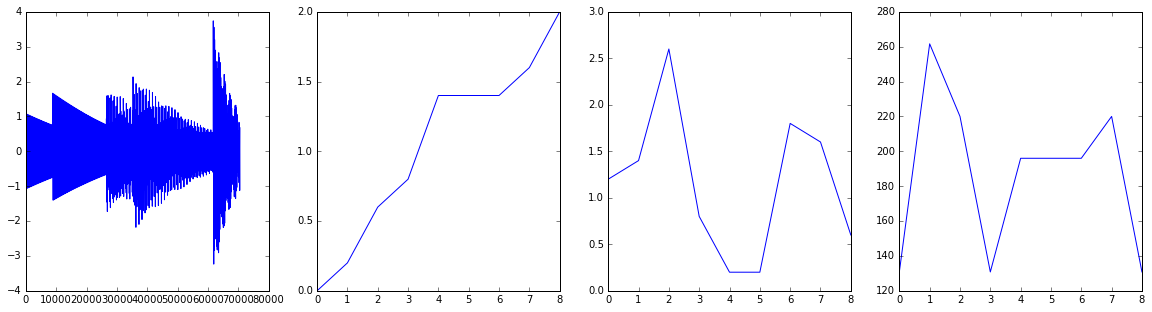

In [39]:
fig = plt.figure(figsize=(20,5))
ax1, ax2, ax3, ax4 = fig.add_subplot(141), fig.add_subplot(142), fig.add_subplot(143), fig.add_subplot(144)

#C3:130.81, B3:246.94, C4:261.63, B4:493.88, C5:523,25
ax1.plot(unified_sound_wave)
ax2.plot(path_first_time)
ax3.plot(path_time_length)
ax4.plot(path_freq)

In [40]:
if is_loop == 1:
    looped_unified_sound_wave = np.array(int(len(unified_sound_wave_melody)/len(raw_unified_sound_wave) + 1)*list(raw_unified_sound_wave))
    unified_sound_wave = looped_unified_sound_wave

max_amp = max(abs(unified_sound_wave))
print(max_amp)
unified_sound_wave = unified_sound_wave/max_amp
wavwrite(unified_sound_wave,"music_w"+str(partition_num_width)+"h"+str(partition_num_height)+".wav")

3.74048681568


In [41]:
img_prm = [partition_num_width, partition_num_height, last_path_order, first_shift, repeatable_num]
msc_prm = [is_cut_loop, cut_loop_num, is_loop, keyname, first_octave, plus_octave, key_id_shift, loop_count, first_time_ratio, time_length_ratio, isnt_degeneratable, bpm, len_id_usage]
prm_loop = 'loop_' + '-'.join(list(map(str, img_prm))) + '_' + '-'.join(list(map(str, msc_prm)))
prm_loop

'loop_3-3-100-1-3_1-1-1-C_mj-3-1-0-4-3-12-0-150-9'

In [42]:
log_id_loop = log_id
reduced_rgb_loop = reduced_rgb
reduced_hsv_loop = reduced_hsv

raw_unified_sound_wave_loop = raw_unified_sound_wave
unified_sound_wave_loop = looped_unified_sound_wave
partition_num_width_loop = partition_num_width
partition_num_height_loop = partition_num_height

## Mix melody and loop ---------------------------------------

In [43]:
unified_sound_wave = unify1d(1*unified_sound_wave_melody, 1*unified_sound_wave_loop)

In [44]:
max_amp = max(abs(unified_sound_wave))
print(max_amp)
unified_sound_wave = unified_sound_wave/max_amp
wavwrite(unified_sound_wave,"music_"+prm_mldy+"_"+prm_loop+"_"+img_name+".wav")

4.83254603532


In [45]:
end_whole_time = time.time()
elapsed_whole_time = end_whole_time - start_whole_time
print(elapsed_whole_time, "sec   ", elapsed_whole_time/60, "min   ", elapsed_whole_time/3600, "hour")

52.804718017578125 sec    0.8800786336263021 min    0.014667977227105035 hour
